# RUBIK'S CUBE COMPETITIONS ANALYSIS

The goal of this notebook is to perform exploratory analysis, and answer some questions about the
World Cube Association's database. We will do this by querying the database using SQL, followed by analysis
and visualization with common python libraries (Pandas, Plotly)

Let's import the necessary libraries!

In [1]:
import mysql.connector
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import datetime
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

Now let's establish a connection to the local database "wca_results" (updated as of 01/10/2021)

In [2]:
wca_db = mysql.connector.connect(
  host="localhost",
  user="root",
  password="1234",
  database="wca_results",
)

And let's take a look at our tables:

In [3]:
wca_tables = pd.read_sql('SHOW TABLES', con=wca_db)

for i in wca_tables['Tables_in_wca_results']:
    query = 'select count(*) from ' + i
    j = pd.read_sql(query, con=wca_db)
    print('There are ' + str(j['count(*)'][0]) + ' rows in ' + str(i))

There are 475 rows in championships
There are 7243 rows in competitions
There are 7 rows in continents
There are 207 rows in countries
There are 4 rows in eligible_country_iso2s_for_championship
There are 21 rows in events
There are 5 rows in formats
There are 149383 rows in persons
There are 433773 rows in ranksaverage
There are 503681 rows in rankssingle
There are 2649564 rows in results
There are 1 rows in rounds
There are 11 rows in roundtypes
There are 1199659 rows in scrambles


Awesome! So we have a handful of tables, the most extensive of which are (perhaps unsurprisingly) RESULTS and SCRAMBLES.
From the database structure alone, I'm tipped off to joining continents/events/formats/persons to likely the RESULTS table,
as these carry necessary information about each round, event, competitor, etc.

Let's consider some intriguing questions we could answer, using this database:<br>
<ol>
    <li>What is the fastest solve time to date in each event?</li>
<!--     <li>What is the history of fastest solve times to date in each event?</li> -->
    <li>Which countries host the most WCA competitions?</li>
    <li>Are these the same countries who produce the best competitors? Who are the most prolific 'winners' in WCA history?</li>
    <li>Who are the most prolific 3x3x3 'winners' in WCA history?</li>
    <li>Progression of 3x3x3 champion solve times over time</li>
</ol>

So, let's write some queries and answer these questions! 

First, let's find out the fastest solve-times in each event across all competitions:<br>
*Note: 'best' has negative values we need to account for, as well as eventId's '333mbf' and '333mbo' and '333fm'*

In [4]:
fastest_each_event_query_text = '''

    select f.personName, f.personId, f.eventId, f.best
    from (
       select eventId, min(best) as minbest
       from results 
       where best > 0
       group by eventId
    ) as x inner join results as f on f.eventId = x.eventId and f.best = x.minbest;
    
'''

fastest_each_event_query = pd.read_sql(fastest_each_event_query_text, con=wca_db) ## use pandas read_sql to query

fastest_each_event_query = fastest_each_event_query.sort_values(by=['best']) ## sorting by 'best'

fastest_each_event_query['best (in seconds)'] = fastest_each_event_query['best'] / 100 ## converting to seconds

relevant_eventIds = (['222', 'magic', 'pyram', 'skewb', 'magic', 'clock', '333', 'sq1', '333oh', # eventIds to keep
                     '333bf', '333f5', '444', 'minx', '555', '444bf', '666', '777', '555bf'])

fastest_each_event_query = fastest_each_event_query[fastest_each_event_query['eventId'].isin(relevant_eventIds)]
                                                     ## excluding egregious eventIds, unpopular & blowing up charts
    
fastest_each_event_query['Person name'] = fastest_each_event_query['personName'].str.split('(').str[0] ## removes possible non-utf8
fastest_each_event_query = fastest_each_event_query[['Person name', 'personId', 'eventId', 'best', 'best (in seconds)']]
    
print(fastest_each_event_query)

            Person name    personId eventId   best  best (in seconds)
3     Maciej Czapiewski  2014CZAP01     222     49               0.49
1          Yuxuan Wang   2009WANG13   magic     69               0.69
4         Dominik Górny  2015GORN01   pyram     91               0.91
8          Andrew Huang  2016HUAN43   skewb     93               0.93
6        Suen Ming Chi   2017CHIS02   clock    329               3.29
5           Yusheng Du   2015DUYU01     333    347               3.47
20  Martin Vædele Egdal  2013EGDA02     sq1    459               4.59
12             Max Park  2012PARK03   333oh    682               6.82
9          Max Hilliard  2015HILL09   333bf   1550              15.50
11      Sebastian Weyer  2010WEYE02     444   1742              17.42
16   Juan Pablo Huanqui  2013HUAN30    minx   2722              27.22
18             Max Park  2012PARK03     555   3492              34.92
14       Stanley Chapel  2016CHAP04   444bf   6251              62.51
19             Max P

Holy cow, some people can solve a Rubik's Cube (er, item?) fast!

Now, what about a visualization?

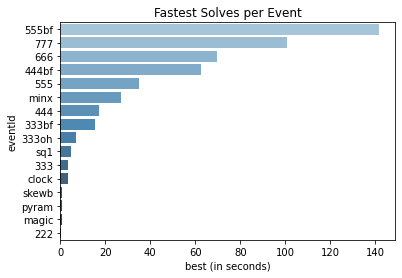

In [5]:
fastest_each_event_query = fastest_each_event_query.sort_values(by='best (in seconds)', ascending=False) ## sort table

ax = sns.barplot(x="best (in seconds)", y="eventId", data=fastest_each_event_query, palette="Blues_d").set_title('Fastest Solves per Event')

I grew up trying to learn to solve the 3x3x3 and it really blows my mind that the fastest solve is *3.47 seconds*. At that point, it almost seems like you know how to solve the cube before the timer starts, and it's simply a matter of how fast you can move your hands. Although I have done some reading about the infamous/famous 'layer skips' :)

That's on top of folks solving cubes blindfolded, and 7x7x7 cubes, all in less than 2 mins 30 seconds. And the 2x2x2 record being 0.49 seconds? That's must be a joke.

Moving on, what about the countries which host the most WCA competitions?

In [6]:
countries_most_comps_text = '''

    select countryId as 'Country', count(*) as 'Total Competitions' from competitions
    group by countryId
    order by count(*) desc
    
'''

countries_most_comps_query = pd.read_sql(countries_most_comps_text, con=wca_db) ## use pandas read_sql to query

print("The 10 countries which have hosted the most competitions:\n")
print(countries_most_comps_query[0:10])

The 10 countries which have hosted the most competitions:

       Country  Total Competitions
0          USA                1459
1        China                 586
2        India                 374
3       Brazil                 292
4       Poland                 253
5        Spain                 207
6       Russia                 200
7       France                 192
8        Japan                 189
9  Philippines                 186


Interesting, but let's dig a little deeper - what if we consider competition size? Perhaps the USA only hosts very tiny competitions and is being over-represented by the current statistic.. Let's find out each competition's entrant size, and join that with the competition info table

In [7]:
competition_sizes = '''

    select competitionId as 'Competition', count(personId) as 'Entrant Size'
    from 
        (
            select distinct competitionId, personId
            from results
        ) as temp_table
    group by competitionId
    order by count(personId) desc
    
'''

competition_sizes_query = pd.read_sql(competition_sizes, con=wca_db) ## use pandas read_sql to query

Now, let's join this with the competitions table & run it again, taking the sum of entrants this time!

In [8]:
countries_competitions_and_competitors_text = '''

    select competitions.countryId as 'Country', count(competitions.id) as 'Total Competitions', 
        sum(tot_competitors.entrant_size) as'Entrant Size' from competitions
    left join 
        (
        
    select competitionId as 'Competition', count(personId) as 'Entrant_Size'
    from 
        (
            select distinct competitionId, personId
            from results
        ) as temp_table
    group by competitionId
    order by count(personId) desc
        
        ) as tot_competitors
    on competitions.id = tot_competitors.Competition
    group by competitions.countryId
    order by sum(tot_competitors.Entrant_Size) desc
    
'''

countries_competitions_and_competitors_query = pd.read_sql(countries_competitions_and_competitors_text, con=wca_db) 
                                    ## use pandas read_sql to query

print("The 10 countries with the most competitions/entrants:\n")
print(countries_competitions_and_competitors_query[0:10])

The 10 countries with the most competitions/entrants:

     Country  Total Competitions  Entrant Size
0        USA                1459      101824.0
1      China                 586       60153.0
2      India                 374       29088.0
3     Poland                 253       18307.0
4     Russia                 200       16378.0
5     Canada                 184       15117.0
6     Brazil                 292       14442.0
7      Spain                 207       11977.0
8  Australia                 171       11166.0
9      Japan                 189       11035.0


Let's plot these results

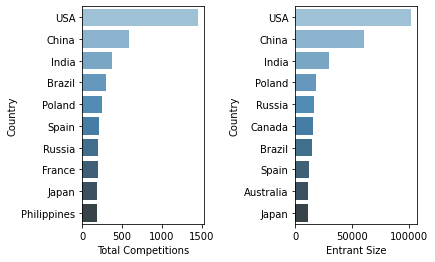

In [9]:
countries_competitions_and_competitors_query = countries_competitions_and_competitors_query.sort_values(by='Total Competitions', ascending=False)

f, axes = plt.subplots(1, 2)

f.subplots_adjust(wspace=0.75)

sns.barplot(  y="Country", x= "Total Competitions", data=countries_competitions_and_competitors_query[0:10], palette="Blues_d" , ax=axes[0])

countries_competitions_and_competitors_query = countries_competitions_and_competitors_query.sort_values(by='Entrant Size', ascending=False)

sns.barplot(  y="Country", x= "Entrant Size", data=countries_competitions_and_competitors_query[0:10], palette="Blues_d" , ax=axes[1])

Welp, looks like the first test gave us a better indicator than imagined. USA/China/India are once again at the top! Brazil seems to have noticeably dropped a couple spots. The Philippines are nowhere to be found. Interesting.

Moving on in a tangential fashion, I wonder how many top competitors are from USA/China/India, considering those 3 are the top in terms of # of competitions as well as # of entrants.

Let's first write a query to discover the most prolific competition winners in Rubik's history:

In [10]:
top_wins_all_comps = '''

    select temp.personName as 'Person', temp.personId, temp.countryId as 'Country', 
        count(temp.personName) as 'Total Wins' from
        (
            select * from results
            left join persons
            on results.personId = persons.id
        ) as temp
    where temp.pos = '1'
    and temp.subid = '1'
    and (temp.roundTypeId = 'c' or temp.roundTypeId = 'f')
    group by temp.personId
    order by count(temp.personName) desc
    
'''

top_wins_all_comps_df = pd.read_sql(top_wins_all_comps, con=wca_db) ## use pandas read_sql to query

top_wins_all_comps_df['Person name'] = top_wins_all_comps_df['Person'].str.split('(').str[0] ## removes possible non-utf8
top_wins_all_comps_df = top_wins_all_comps_df[['Person name', 'personId', 'Country', 'Total Wins']]

print("The 25 cubers by # of 1st place victories:\n")
print(top_wins_all_comps_df[0:25])

The 25 cubers by # of 1st place victories:

                     Person name    personId         Country  Total Wins
0                    Bence Barát  2008BARA01         Hungary         635
1                 Feliks Zemdegs  2009ZEMD01       Australia         621
2                Erik Akkersdijk  2005AKKE01     Netherlands         448
3                      Mats Valk  2007VALK01     Netherlands         358
4            Martin Vædele Egdal  2013EGDA02         Denmark         322
5                 Michał Halczuk  2006HALC01          Poland         312
6                       Max Park  2012PARK03             USA         297
7              Clément Cherblanc  2014CHER05          France         278
8         Vincent Hartanto Utomo  2010UTOM01       Indonesia         236
9   Carlos Méndez García-Barroso  2010GARC02           Spain         231
10                     Dan Cohen  2007COHE01             USA         231
11                    Robert Yau  2009YAUR01  United Kingdom         225
12     

Of course, # of 1st place victories is not a direct correlation to Rubik's skill, but based on this information I am a bit surprised at the spread! There's a handful of USA, but nearly no China/India. On the other hand there are more Germany & Netherlands than I expected.

And drilling down a bit deeper, who are the most prolific 3x3x3 Rubik's Competition winners in WCA history?

In [11]:
top_wins_333 = '''
    
    select temp.personName as 'Person', temp.personId, temp.countryId as 'Country', 
        count(temp.personName) as 'Total Wins' from
        (
            select * from results
            left join persons
            on results.personId = persons.id
        ) as temp
    where temp.pos = '1'
    and temp.eventId = '333'
    and temp.subid = '1'
    and (temp.roundTypeId = 'c' or temp.roundTypeId = 'f')
    group by temp.personId
    order by count(temp.personName) desc
    
'''

top_wins_333_df = pd.read_sql(top_wins_333, con=wca_db) ## use pandas read_sql to query

top_wins_333_df['Person name'] = top_wins_333_df['Person'].str.split('(').str[0] ## removes possible non-utf8
top_wins_333_df = top_wins_333_df[['Person name', 'personId', 'Country', 'Total Wins']]

print("The 25 3x3x3 cubers by # of 1st place victories:\n")
print(top_wins_333_df[0:25])

The 25 3x3x3 cubers by # of 1st place victories:

                     Person name    personId      Country  Total Wins
0                 Feliks Zemdegs  2009ZEMD01    Australia          99
1                      Mats Valk  2007VALK01  Netherlands          81
2                       Max Park  2012PARK03          USA          69
3                 Anthony Brooks  2008SEAR01          USA          58
4              Michał Pleskowicz  2009PLES01       Poland          54
5                    Jiayu Wang   2010WANG53        China          53
6                Erik Akkersdijk  2005AKKE01  Netherlands          48
7   Carlos Méndez García-Barroso  2010GARC02        Spain          46
8            Cornelius Dieckmann  2009DIEC01      Germany          45
9                   Rowe Hessler  2007HESS01          USA          44
10                  Dylan Miller  2015MILL01          USA          44
11                 Philipp Weyer  2010WEYE01      Germany          43
12                 Patrick Ponce  2012PO

And for fun, how about a chart of the top 10:

Text(0.5, 1.0, 'Most 3x3x3 Competition Wins')

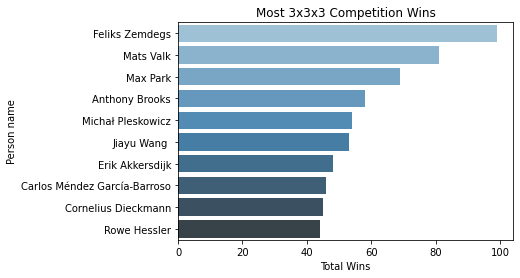

In [12]:
ax = sns.barplot(x="Total Wins", y="Person name", data=top_wins_333_df[0:10], palette="Blues_d")
ax.set_title('Most 3x3x3 Competition Wins')

Distribution of Top 25 Rubik's solvers over world countries:

In [13]:
tot_333_winners_country = top_wins_333_df[['Country', 'Person name']][0:25].groupby('Country').agg('count').reset_index()
print(tot_333_winners_country.sort_values(by='Person name', ascending=False))

tot_333_winners_country = tot_333_winners_country.sort_values(by='Person name', ascending=False)

        Country  Person name
12          USA            6
3       Germany            3
8        Poland            3
1         China            2
4         India            2
6   Netherlands            2
0     Australia            1
2       Denmark            1
5         Japan            1
7          Peru            1
9        Russia            1
10        Spain            1
11       Taiwan            1


Visualized

Text(0, 0.5, 'Country')

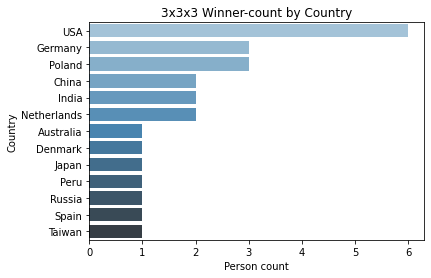

In [14]:
ax = sns.barplot(x="Person name", y="Country", data=tot_333_winners_country, palette="Blues_d")

ax.set_title('3x3x3 Winner-count by Country')
ax.set_xlabel('Person count')
ax.set_ylabel('Country')

And finally, let's take a look at the history of 3x3x3 competition winners!

In [15]:
query_text = '''

    select results.personName, results.best, competitions.year, competitions.month, competitions.endDay
    from results 
    left join competitions
    on results.competitionId = competitions.id
    where results.eventId = '333'
    and (results.roundTypeId = 'c' or results.roundTypeId = 'f')
    and results.pos = '1'
    and results.best > '0'
    and competitions.year <> '1982'

'''

query_df = pd.read_sql(query_text, con=wca_db) ## read query

query_df['date'] = query_df['month'].map(str) + '/' + query_df['endDay'].map(str) + '/' + query_df['year'].map(str) ## format date stuff
query_df['date'] = pd.to_datetime(query_df['date'])

query_df = query_df.sort_values(by=['date']) ## sorting & dropping index
query_df = query_df.reset_index(drop=True)

query_df['best (in seconds)'] = query_df['best'] / 100

query_df['Person name'] = query_df['personName'].str.split('(').str[0] ## removes possible non-utf8
df_for_visual = query_df[['Person name', 'date', 'best (in seconds)']]

print(df_for_visual)

              Person name       date  best (in seconds)
0             Dan Knights 2003-08-24              18.76
1         Ron van Bruchem 2003-10-11              18.65
2       Shotaro Makisumi  2004-01-24              14.76
3       Shotaro Makisumi  2004-04-03              12.11
4         Thomas Templier 2004-04-16              18.84
...                   ...        ...                ...
6637         Yiheng Wang  2021-01-03               5.79
6638          Jiazhou Li  2021-01-03               6.65
6639  Adrien Auvray Matyn 2021-01-09               7.48
6640          Zijian Cai  2021-01-09               6.46
6641       Xianjing Wang  2021-01-09               7.24

[6642 rows x 3 columns]


Dataframe = prepared, let's visualize!

Text(0, 0.5, 'Time (seconds)')

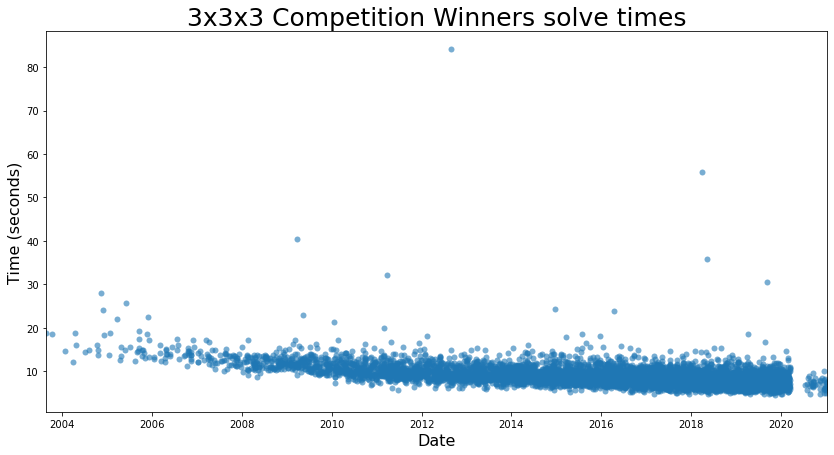

In [16]:
plt.figure(figsize=(14, 7))

ax = sns.scatterplot(data=df_for_visual, x="date", y="best (in seconds)", linewidth=0, alpha=0.6)

ax.set_xlim(df_for_visual['date'].min(), df_for_visual['date'].max())

ax.set_title('3x3x3 Competition Winners solve times', fontsize=25)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel("Time (seconds)",fontsize=16)

Dang, if I had any hope for entering these competitions, that has surely been crushed.

Also interesting is the gap between April & July 2020, which I have to assume is due to COVID-19 restrictions.

Thanks for coming along for this rough analysis :) I hope you learned something, or at least had fun!